## Project Overview

Each year, there are roughly 100,000 thunderstorms in the US and an estimated 16 million thunderstorms worldwide. Improving scientific knowledge of storms has the potential to save thousands of lives and is essential for charting the world's weather and climate systems. Numerous severe weather events are studied by organizations and agencies including the National Severe Storms Laboratory (NSSL), the National Oceanic and Atmospheric Administration (NOAA), the Hazardous Weather Test Lab (HWT), and the National Weather Service (NWS): hurricanes, tornadoes, blizzards, floods, droughts and wildfires. The goal of NOAA's forecasting initiative is to increase the accuracy of severe weather predictions up to one week in advance.

But according to scientific literature, what exactly is a storm and how does it appear? storms are formed when warm, less dense, moist air rises into cold air. The warm air then cools down, which causes moisture.The cooled air drops lower, warms, and then rises once more. This circuit of rising and falling air is called a convection cell. A cloud will form on a small scale, but a storm may develop if this occurs in an environment with lots of air and moisture.

I will try to reproduce and highlight those physical phenomenons in a simple way at a macroscopic level by studying the impact of humidity and temperature on the formation of storms. I will use raw data from sensors in the US. The datasets I am using are provided by the National Oceanic and Atmospheric Administration (NOAA). In particular, I used five main datasets in this study:
I used two datasets reporting storms from 2020, as well as three datasets with daily temperature, daily wind and daily precipitation measured by weather stations in the Global Historical Climatology Network for January to December 2020. This notebook will show the main results I was able to obtain by playing with Xarrays, csv files and meteorological data.

In [1]:
# importing libraries
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import glob
import urllib.request
import xarray as xr
import calendar
import warnings
warnings.filterwarnings("ignore")

## Storms

In [2]:
df_storm = pd.read_csv('storm.csv')
df_storm2 = pd.read_csv('storm2.csv')

In [3]:
df_temp = df_storm2[["EVENT_ID", "STATE"]]
df_temp2 = df_storm[["YEARMONTH", "EPISODE_ID", "EVENT_ID", "LATITUDE", "LONGITUDE"]]
df = df_temp2.merge(df_temp)
df2=df[(df["LATITUDE"]>20) & (df["LATITUDE"]<50) & (df["LONGITUDE"]>-125)]

In [4]:
n = df.groupby("STATE").count().reset_index().rename(columns={'YEARMONTH': 'NUMBER OF STORM EVENTS'})
n = n[["STATE", "NUMBER OF STORM EVENTS"]]

In [5]:
us = gpd.read_file('cb_2018_us_state_500k.shp')
us = us.to_crs('EPSG:4326')
us = us.rename(columns={'NAME': 'STATE'})
us['STATE'] = us['STATE'].str.upper()
s = us.merge(n)

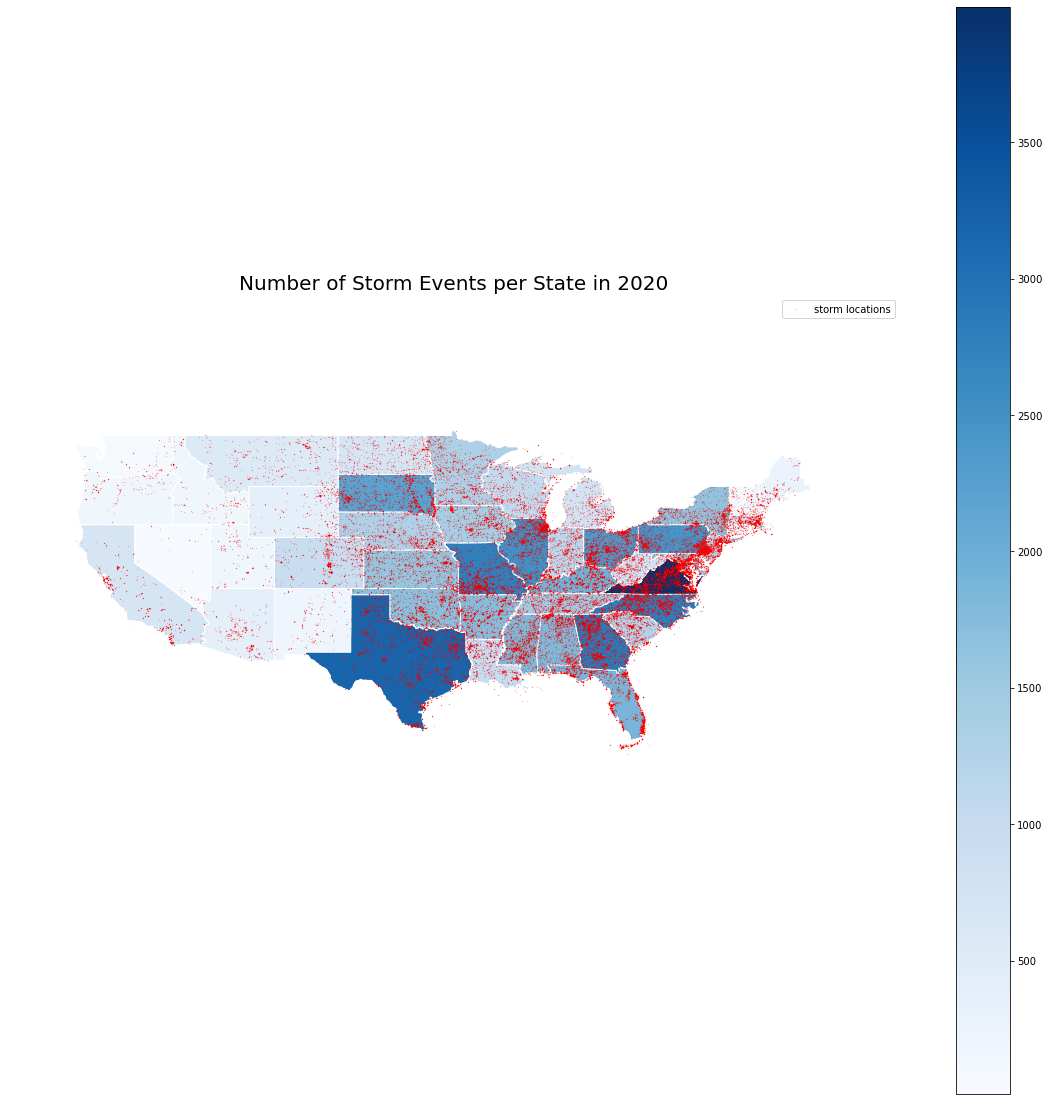

In [6]:
fig, gax = plt.subplots(figsize = (20,20))
s.plot(ax=gax, edgecolor='white', column='NUMBER OF STORM EVENTS', legend=True, cmap='Blues', )

geometry = [Point(xy) for xy in zip(df2['LONGITUDE'], df2['LATITUDE'])]
gdf = GeoDataFrame(df2, geometry=geometry)   
gdf.plot(ax=gax, color='red', markersize=0.01, label='storm locations')
plt.legend()
plt.xlim(-130,-60)
plt.ylim(20,60)
plt.axis('off')
plt.title("Number of Storm Events per State in 2020", fontsize=20)
plt.show()

This first plot shows the number of storm events reported in the United States throughout the year 2020. It seems clear that the South-East part of the coutry is the most impacted by those extreme events. We will understand later in this report why it is the case. Most of the storms are created near water, which makes sense based on the previous explanation of the formation of a storm: more water implies more evaporation and therefore more moisture, so an increasing chance of forming a storm.

In [7]:
n1 = n.nlargest(10, ['NUMBER OF STORM EVENTS'])

Text(0.5, 1.0, 'Number of Storms per State during 2020 (top 10)')

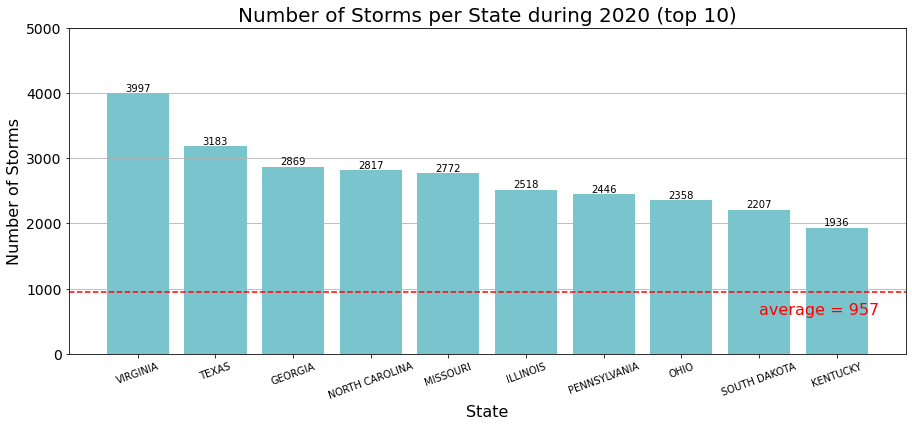

In [8]:
fig, ax = plt.subplots(figsize = (15,6))
ax.grid(axis='y')
a = ax.bar(n1['STATE'],n1['NUMBER OF STORM EVENTS'], color='#7AC5CD')
ax.bar_label(a)
plt.axhline(y=956.77, color='r', linestyle='dashed')
plt.text(8, 600, 'average = 957', color='r', fontsize = 16)
plt.xlabel('State', fontsize=16)
plt.ylabel('Number of Storms', fontsize=16)
plt.yticks(np.arange(0, 5500, step=1000), fontsize=14)
ax.tick_params(axis='x', labelrotation = 20)
plt.title('Number of Storms per State during 2020 (top 10)', fontsize=20)

This plot confirms what was stated previously, a higher number of storms occurs in the South, South-East and East part of the US. The most affected state is Virginia with almost 4000 storms per year (4 times the average).

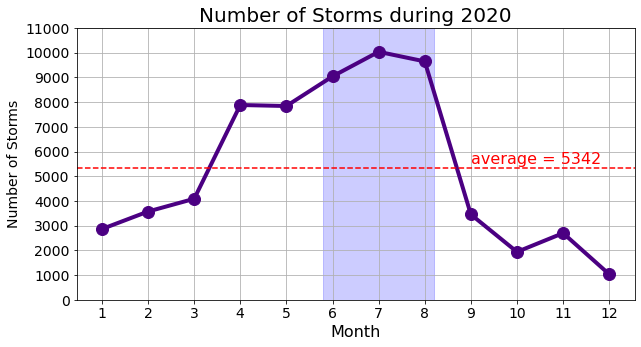

In [9]:
y = df.groupby('YEARMONTH').count().reset_index()
fig, ax = plt.subplots(figsize = (10,5))
plt.plot(y['YEARMONTH']-202000,y['STATE'], linewidth=4, color='#4B0082', markersize=12,marker='o')
plt.axhline(y=5342, color='r', linestyle='dashed')
plt.grid()
plt.text(9, 5500, 'average = 5342', color='r', fontsize = 16)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Number of Storms', fontsize=14)
plt.xticks(np.arange(1, 13, step=1), fontsize=14)
plt.yticks(np.arange(0, 12000, step=1000), fontsize=14)
plt.title('Number of Storms during 2020', fontsize=20)
ax.axvspan(5.8, 8.2, alpha=0.2, color='b')

This plot shows that a majority of storms are formed during Summer, which makes sense with higher temperature and more moisture at this period of the year. Around 60,000 storms have been reported in the dataset.

In the following parts, I am going to study more precisely precipitation, temperature and wind impact on storm formation.

## Precipitation and Humidity

In [12]:
df_2020 = xr.open_dataset('precip.V1.0.2020.nc')
df_month = df_2020.groupby('time.month').sum()
df2['LONG'] = df2['LONGITUDE'] + 360

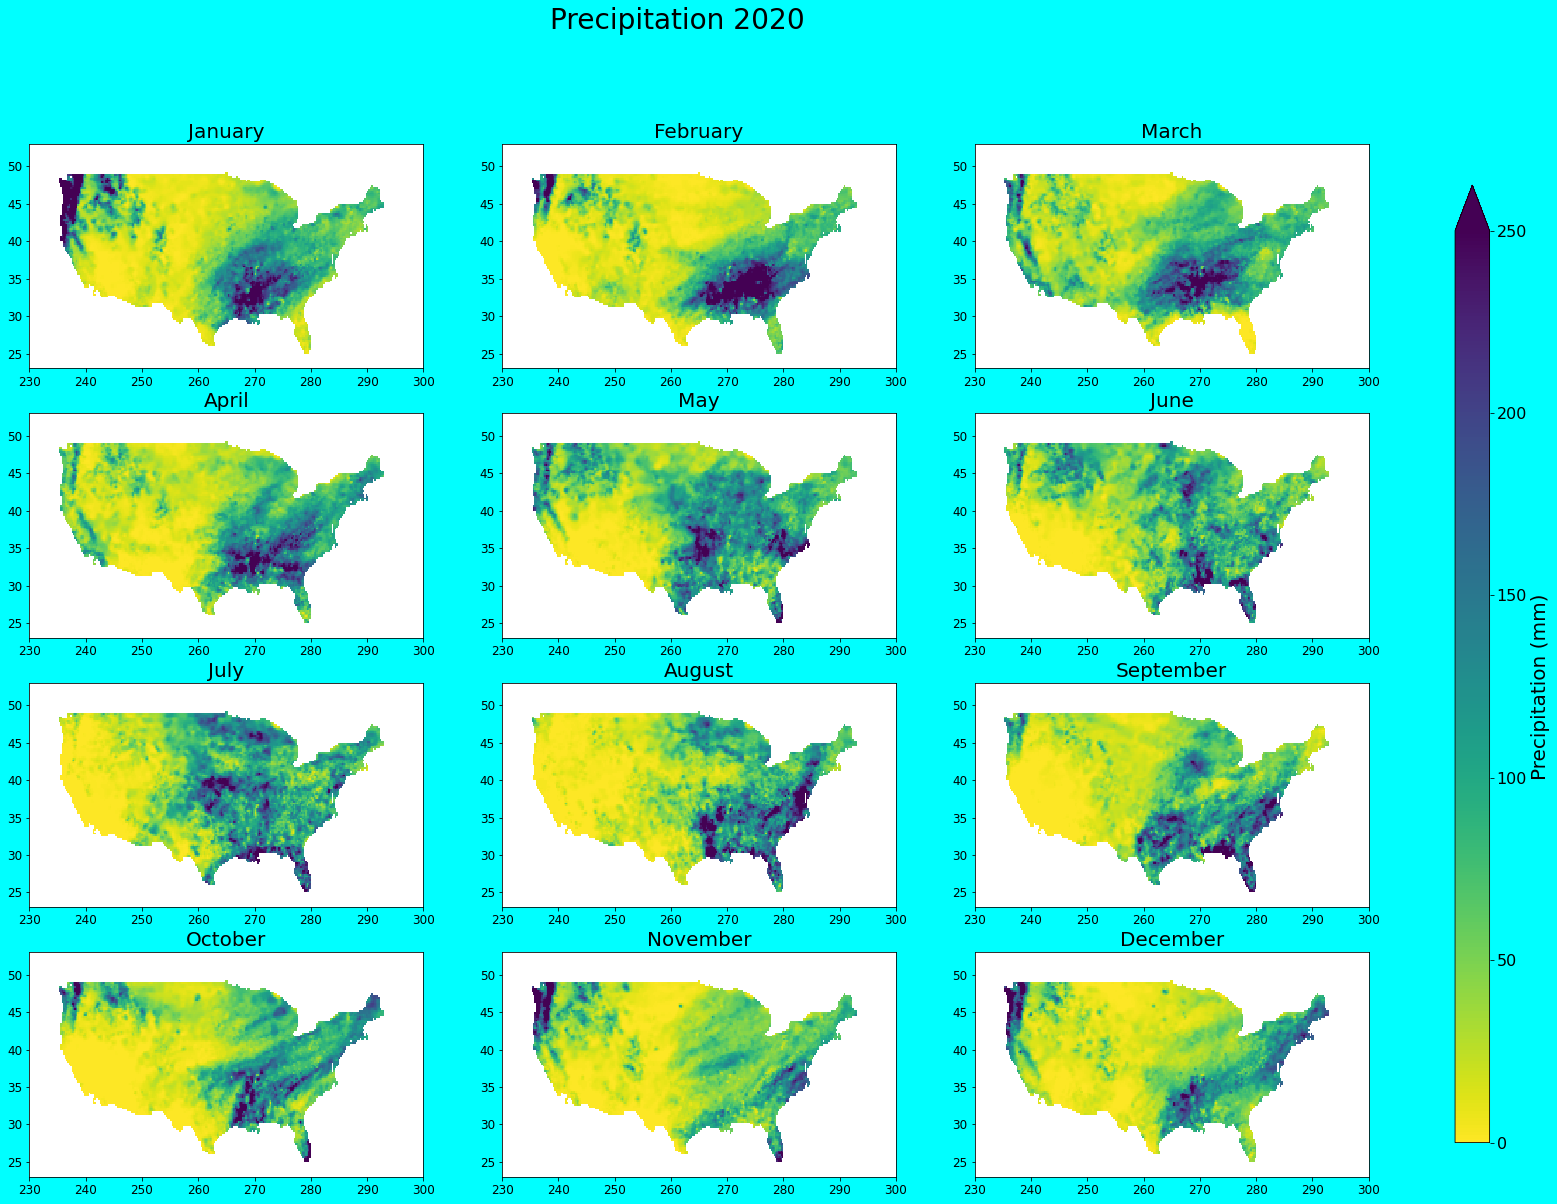

In [13]:
landmask = df_2020.precip.sum(dim='time')>0
fig = plt.figure(figsize=(24,19), facecolor='cyan')
n_rows, n_cols = 4,3
fig.suptitle('Precipitation 2020', fontsize=28)
for i in range(1, 13):
    plt.subplot(n_rows, n_cols, i)
    data = df_month.precip[i-1, :, :].where(landmask)
    p = plt.pcolormesh(df_month.lon, df_month.lat, data, vmax = 250, cmap = 'viridis_r') 
    plt.title(calendar.month_name[data.month.values], fontsize = 20)
    plt.xlim([230,300])
    plt.ylim([23,53])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)

cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = plt.colorbar(cax=cax, orientation='vertical', extend = 'max')
cb.ax.tick_params(labelsize=16)
cb.set_label(label='Precipitation (mm)', size=20)

This plot is the monthly average precipitation in the US. Humidity and precipitation are two different parameters, but linked together. High level of precipitation implies an increasing relative humidity because of the evaporation. Let's fin out how precipitation and storms are correlated. 

In [14]:
st = {}
for i in range(1,13):
    st[i] = df2[df2["YEARMONTH"]-202000==i]

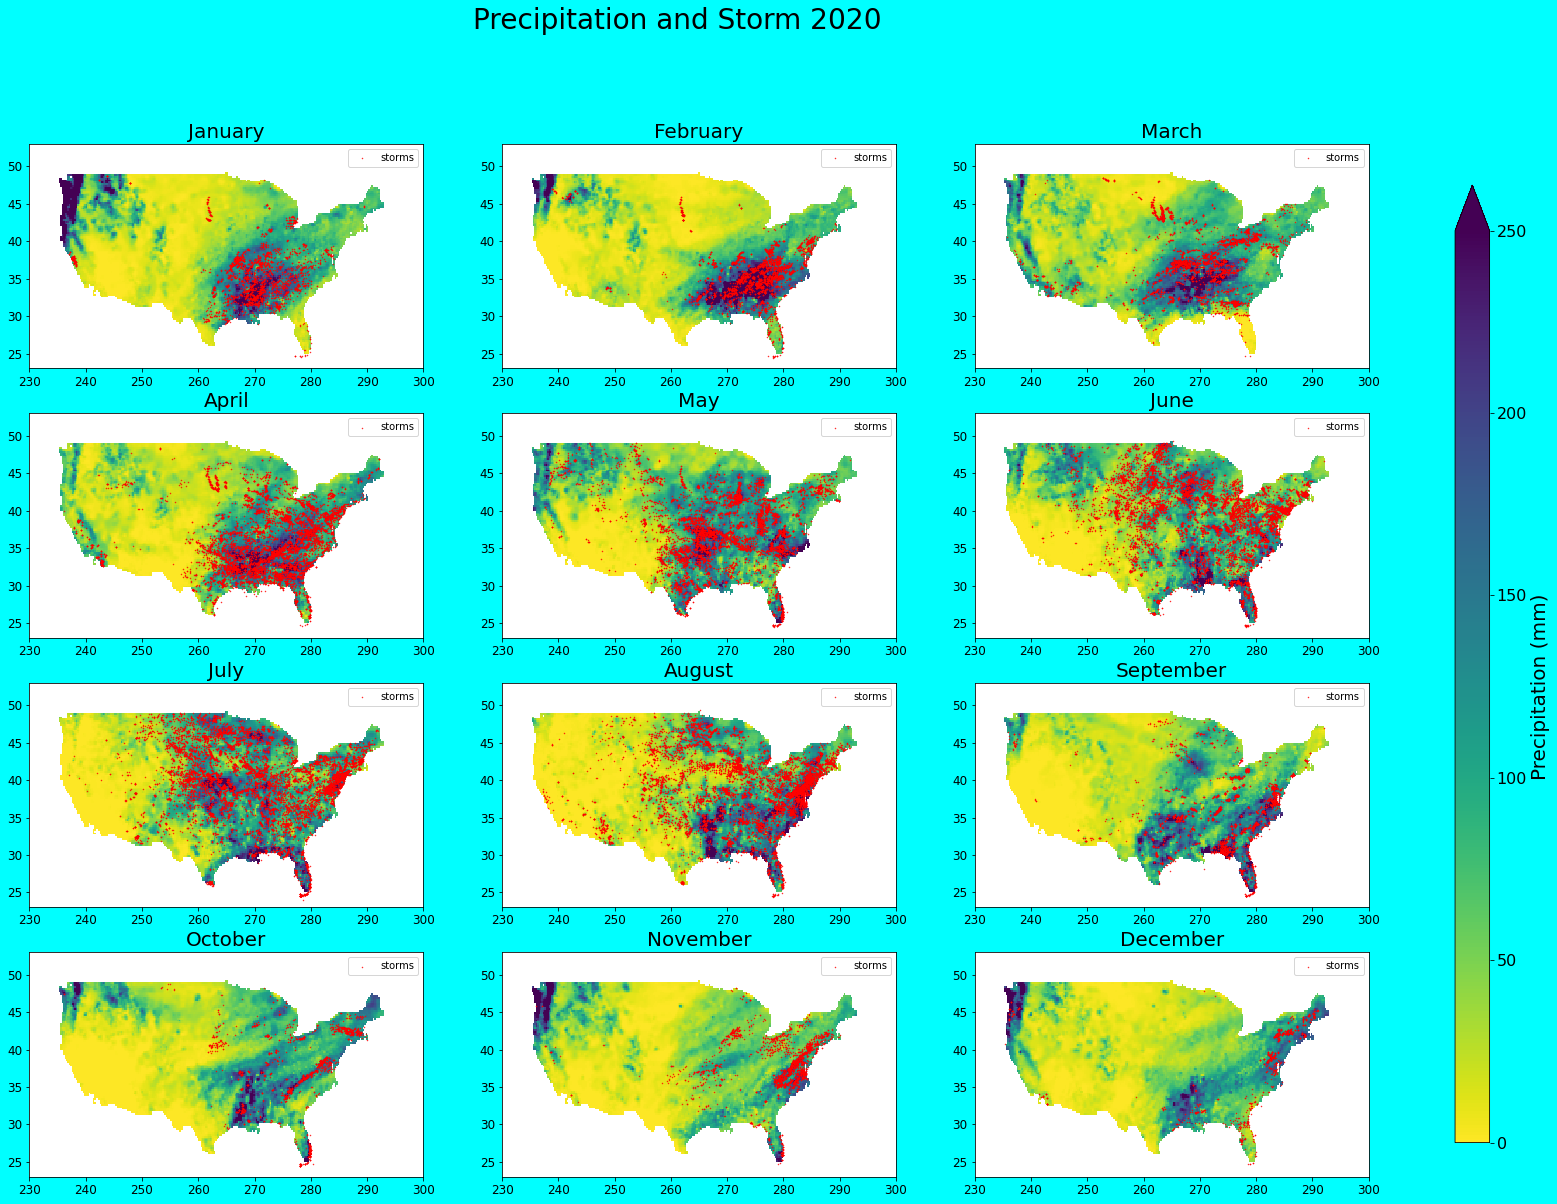

In [15]:
landmask = df_2020.precip.sum(dim='time')>0
fig = plt.figure(figsize=(24,19), facecolor='cyan')
n_rows, n_cols = 4,3

fig.suptitle('Precipitation and Storm 2020', fontsize=28)
for i in range(1, 13):
    plt.subplot(n_rows, n_cols, i)
    data = df_month.precip[i-1, :, :].where(landmask)
    plt.scatter(st[i]['LONG'], st[i]['LATITUDE'], c='r', s=0.2, marker='o', label='storms', zorder=1)
    p = plt.pcolormesh(df_month.lon, df_month.lat, data, vmax = 250, cmap = 'viridis_r', zorder=0)
    plt.legend()
    plt.title(calendar.month_name[data.month.values], fontsize = 20)
    plt.xlim([230,300])
    plt.ylim([23,53])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = plt.colorbar(cax=cax, orientation='vertical', extend = 'max')
cb.ax.tick_params(labelsize=16)
cb.set_label(label='Precipitation (mm)', size=20)

By plotting the storm locations during the year, it appears that the level of precipitation and the number of storms are strongly linked. In particular, this is the case for all the South-East part of the country and it is spreading as Summer approaches. Where there is a storm, there are high precipitations (this is a necessary condition, and this is also a retroactive action as the more storms occured, the higher the precipitation levels). However, somes places with high precipitations do not necessarily form storms. This the case in the North West of the country (more visible during Winter). Another parameter we are going to explore should therefore play a key role in the formation of storms and extreme events: temperature.

## Temperature

In [16]:
df_t = pd.read_csv("daily_TEMP_2020.csv")
df_temp_2020 = df_t[['Latitude', 'Longitude', 'Date Local', 'Arithmetic Mean', 'State Name']]
df_temp_2020 = df_temp_2020.rename(columns={"Date Local": "Date", 
                                            "Arithmetic Mean":"Temperature", 
                                            "State Name":"STATE"})
df_temp_2020 = df_temp_2020[df_temp_2020['Longitude']>-130]

Text(0.5, 1.0, 'Sensors Position')

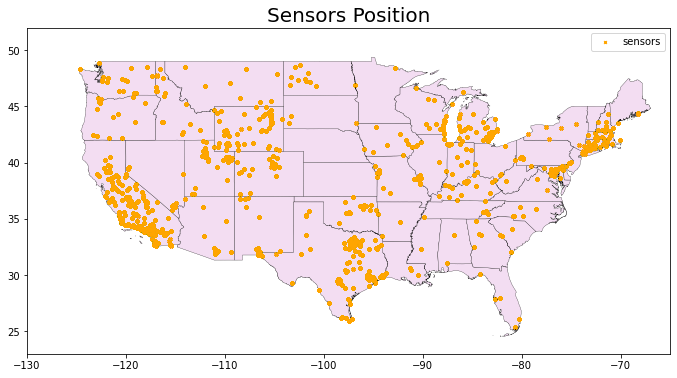

In [17]:
fig, gax = plt.subplots(figsize = (12,6))
s.plot(ax=gax, edgecolor='black', color="#F3DDF2", linewidth=.25)
plt.scatter(df_temp_2020['Longitude'],df_temp_2020['Latitude'], c='orange', s=7, marker='x', label='sensors')
plt.xlim(-130,-65)
plt.ylim(23,52)
plt.legend()
plt.title('Sensors Position', fontsize=20)

This first plot shows the position of each sensors used to retrieve the data. It is important to notice that these sensors are not divided fairly accross all states. Some states have very few data and are therefore not totally representative.

In [18]:
df_temp_2020['Date']=pd.to_datetime(df_temp_2020["Date"]).dt.strftime('%m')
df_temp_2020['Date'] = df_temp_2020['Date'].astype(str).astype(int)
dft = df_temp_2020.groupby(["STATE", "Date"])["Temperature"].mean().to_frame().reset_index()
dft['STATE']=dft['STATE'].str.upper()
t = us.merge(dft)

In [19]:
d = {}
for i in range(1,13):
    d[i] = t[t["Date"]==i]

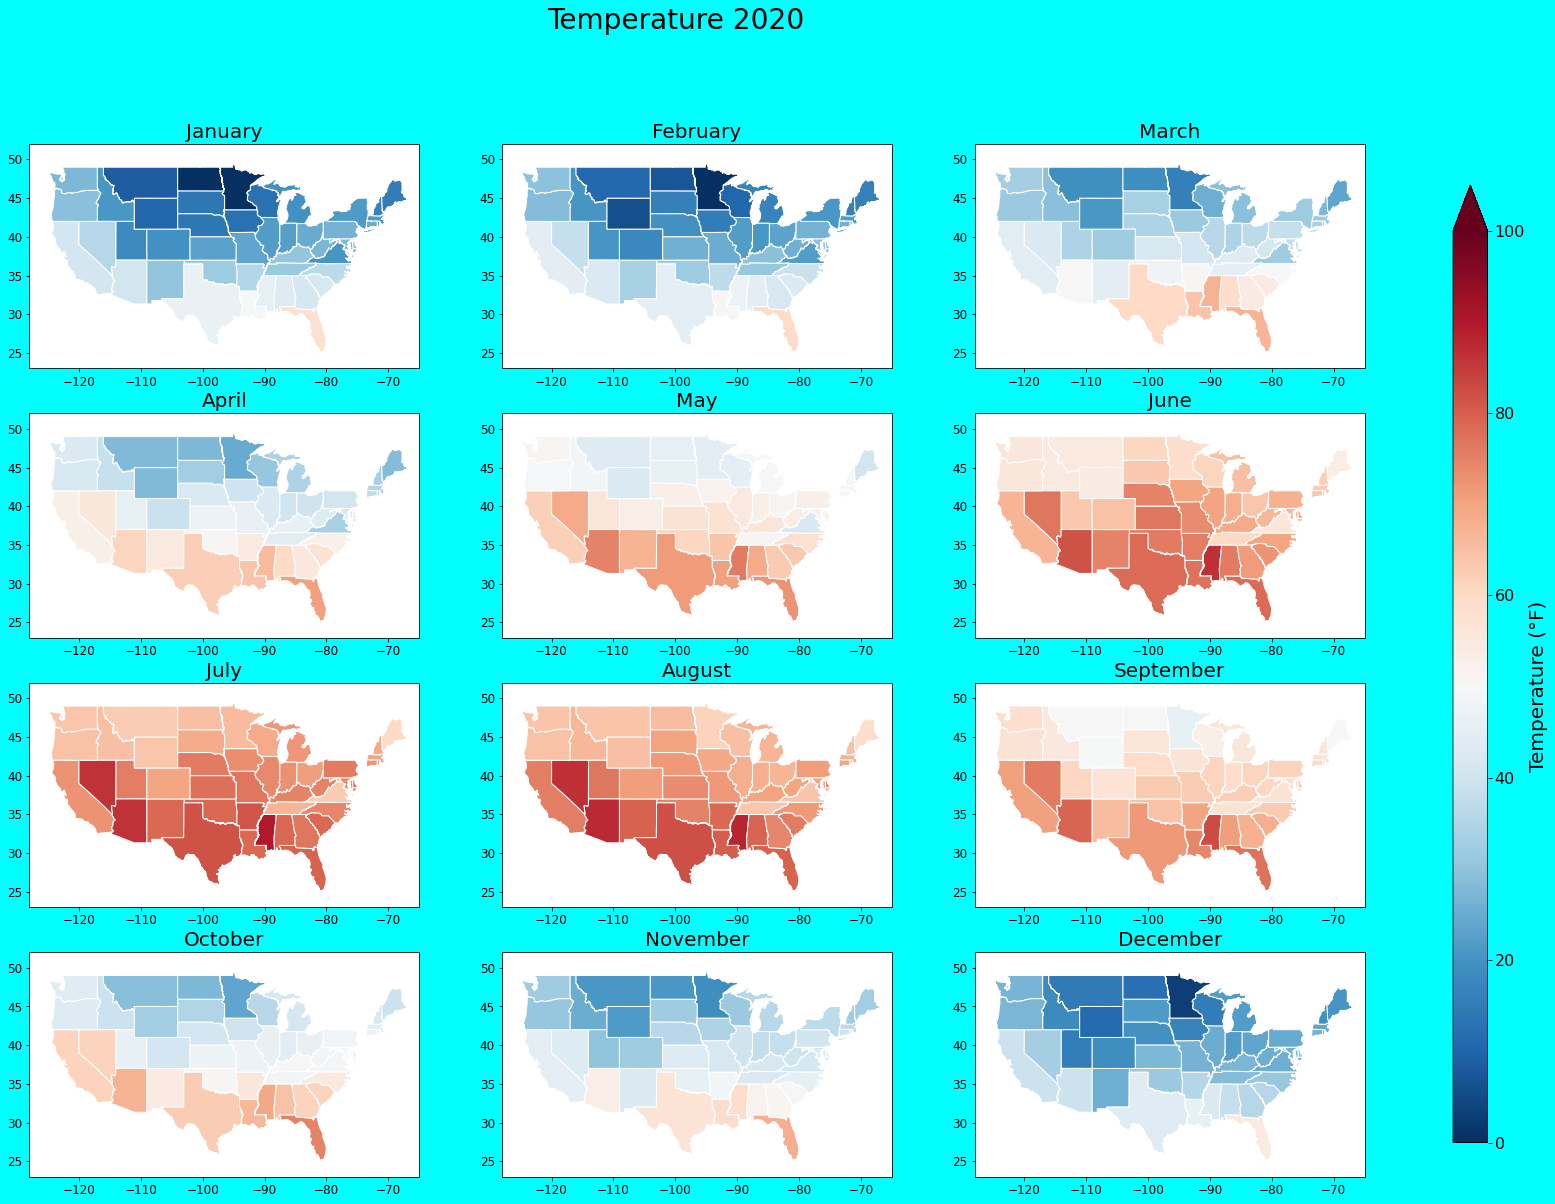

In [20]:
nrows,ncols=4,3
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9], [ax10, ax11, ax12]] = plt.subplots(nrows, 
                                                                                            ncols,
                                                                                            figsize = (24,19),
                                                                                            facecolor='cyan')
l = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]
fig.suptitle('Temperature 2020', fontsize=28)
norm = colors.Normalize(vmin=15, vmax=100)
for i in range (1,13):
    plt.subplot(nrows, ncols, i)
    data = df_month.precip[i-1, :, :].where(landmask)
    p = plt.pcolormesh(df_month.lon*0, df_month.lat*0, data, vmax = 100, cmap = 'RdBu_r')
    d[i].plot(ax=l[i-1], edgecolor='white', column='Temperature', legend=False, cmap='RdBu_r', norm=norm)
    plt.title(calendar.month_name[data.month.values], fontsize = 20)
    plt.xlim(-128,-65)
    plt.ylim(23,52)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)

cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = plt.colorbar(cax=cax, orientation='vertical', extend = 'max')
cb.ax.tick_params(labelsize=16)
cb.set_label(label='Temperature (°F)', size=20)

This plot of the average temperature per state per month is not very surprising. The closer from the Equator, the hotter. It is interesting to notice that for the same latitude, States in the East or the West do not have big differences in temperature. West states are even hotter on average throughout the year. It proves that temperature alone does not explain storms, otherwise we would have seen more storms in Nevada for instance, but that was not the case.

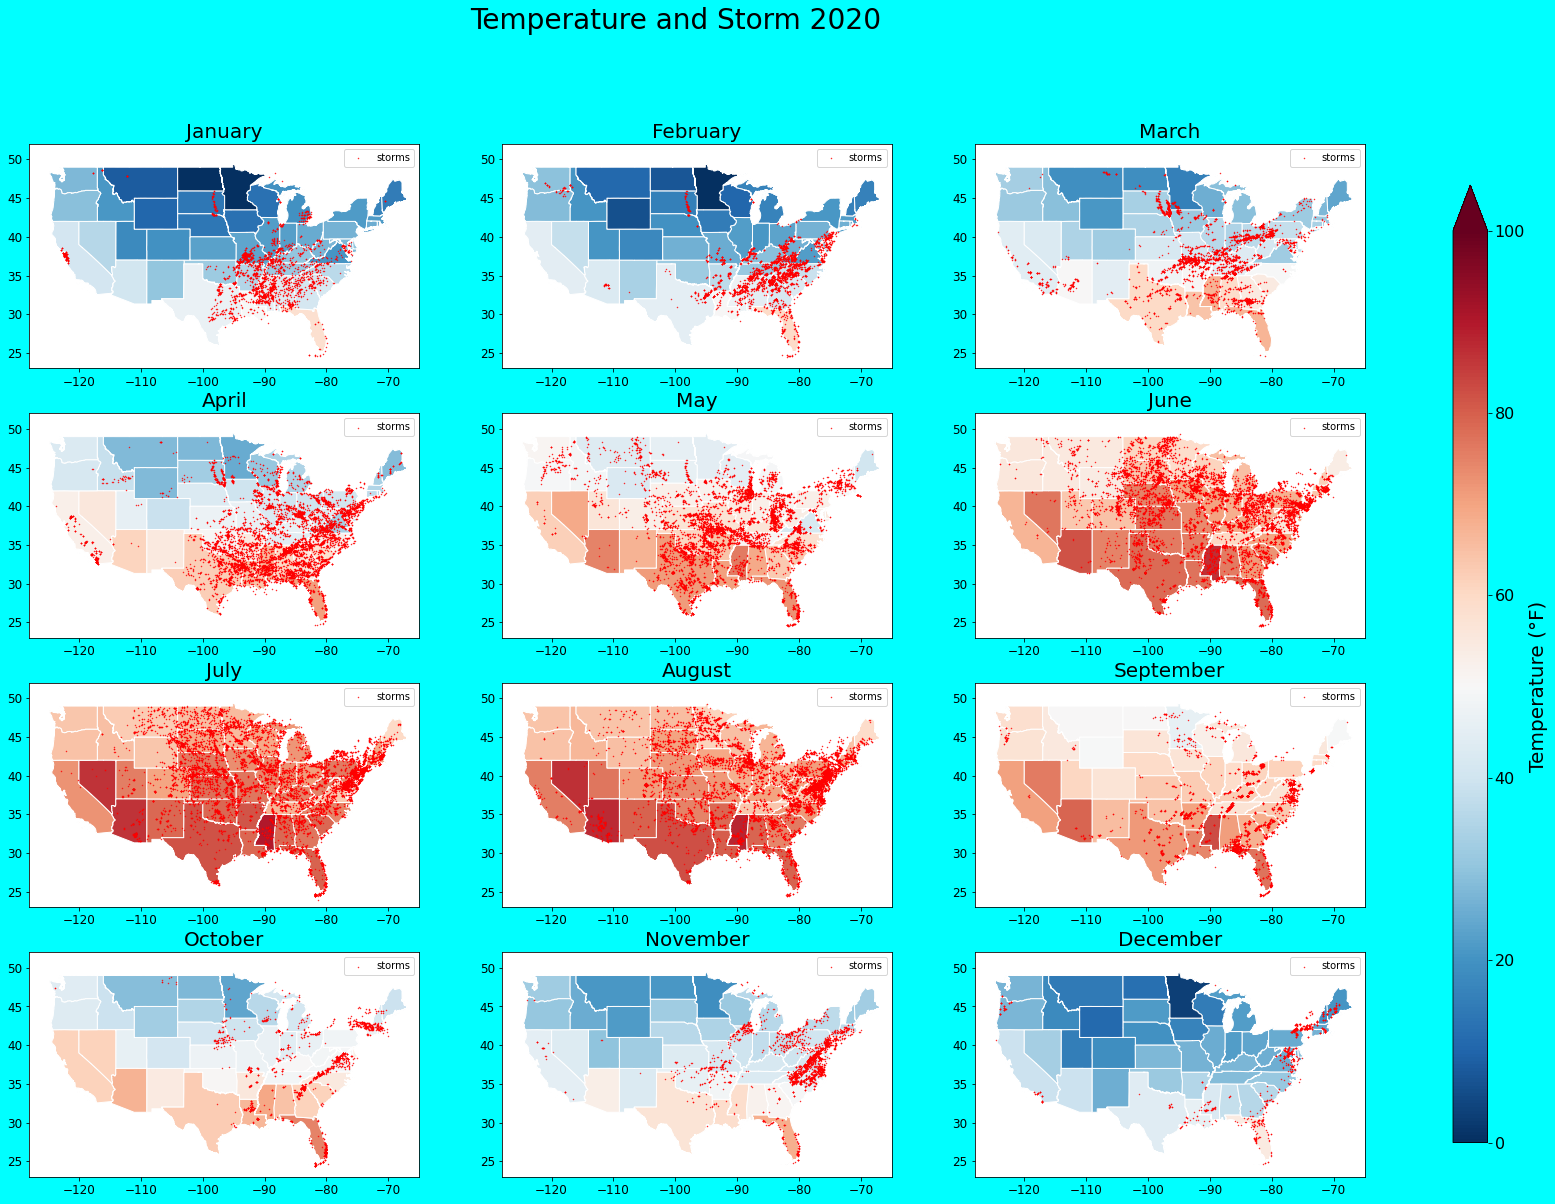

In [21]:
nrows,ncols=4,3
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9], [ax10, ax11, ax12]] = plt.subplots(nrows, 
                                                                                            ncols,
                                                                                            figsize = (24,19),
                                                                                            facecolor='cyan')
l = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]
fig.suptitle('Temperature and Storm 2020', fontsize=28)
norm = colors.Normalize(vmin=15, vmax=100)

for i in range (1,13):
    plt.subplot(nrows, ncols, i)
    data = df_month.precip[i-1, :, :].where(landmask)
    plt.scatter(st[i]['LONGITUDE'], st[i]['LATITUDE'], c='r', s=0.2, marker='o', label='storms', zorder=2)
    p = plt.pcolormesh(df_month.lon*0, df_month.lat*0, data, vmax = 100, cmap = 'RdBu_r', zorder=0)
    d[i].plot(ax=l[i-1], edgecolor='white', column='Temperature', legend=False, cmap='RdBu_r', norm=norm, zorder=1)
    plt.title(calendar.month_name[data.month.values], fontsize = 20)
    plt.xlim(-128,-65)
    plt.ylim(23,52)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend()

cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = plt.colorbar(cax=cax, orientation='vertical', extend = 'max')
cb.ax.tick_params(labelsize=16)
cb.set_label(label='Temperature (°F)', size=20)

This plot adds the storm locations and confirms all that was said previously: Precipitation and Temperature combined seem to be sufficient to determine with a relatively good accuracy the formation of storm. This explains why some states with high precipitation but low temperature or low temperature but high precipitation do not have much storms. Also, it is worth noticing that the Pacific Ocean has cooler temperature (so less evaporation), which can also explain why the West coast is spared from this type of natural disaster. On the contrary, California (high temperature and relatively dry air) will be more impacted by fires and droughts.

## Wind 

In [25]:
df_w = pd.read_csv("daily_WIND_2020.csv")
df_w_2020 = df_w[['Latitude', 'Longitude', 'Date Local', 'Arithmetic Mean', 'State Name']]
df_w_2020 = df_w_2020.rename(columns={"Date Local": "Date", 
                                            "Arithmetic Mean":"Wind Speed", 
                                            "State Name":"STATE"})
df_w_2020 = df_w_2020[df_w_2020['Longitude']>-130]
df_w_2020['Wind Speed']=df_w_2020['Wind Speed']*0.115078
df_w_2020['Date']=pd.to_datetime(df_w_2020["Date"]).dt.strftime('%m')
df_w_2020['Date'] = df_w_2020['Date'].astype(str).astype(int)
dfw = df_w_2020.groupby(["STATE", "Date"])["Wind Speed"].mean().to_frame().reset_index()
dfw['STATE']=dfw['STATE'].str.upper()
w = us.merge(dfw)

In [26]:
dd = {}
for i in range(1,13):
    dd[i] = w[w["Date"]==i]

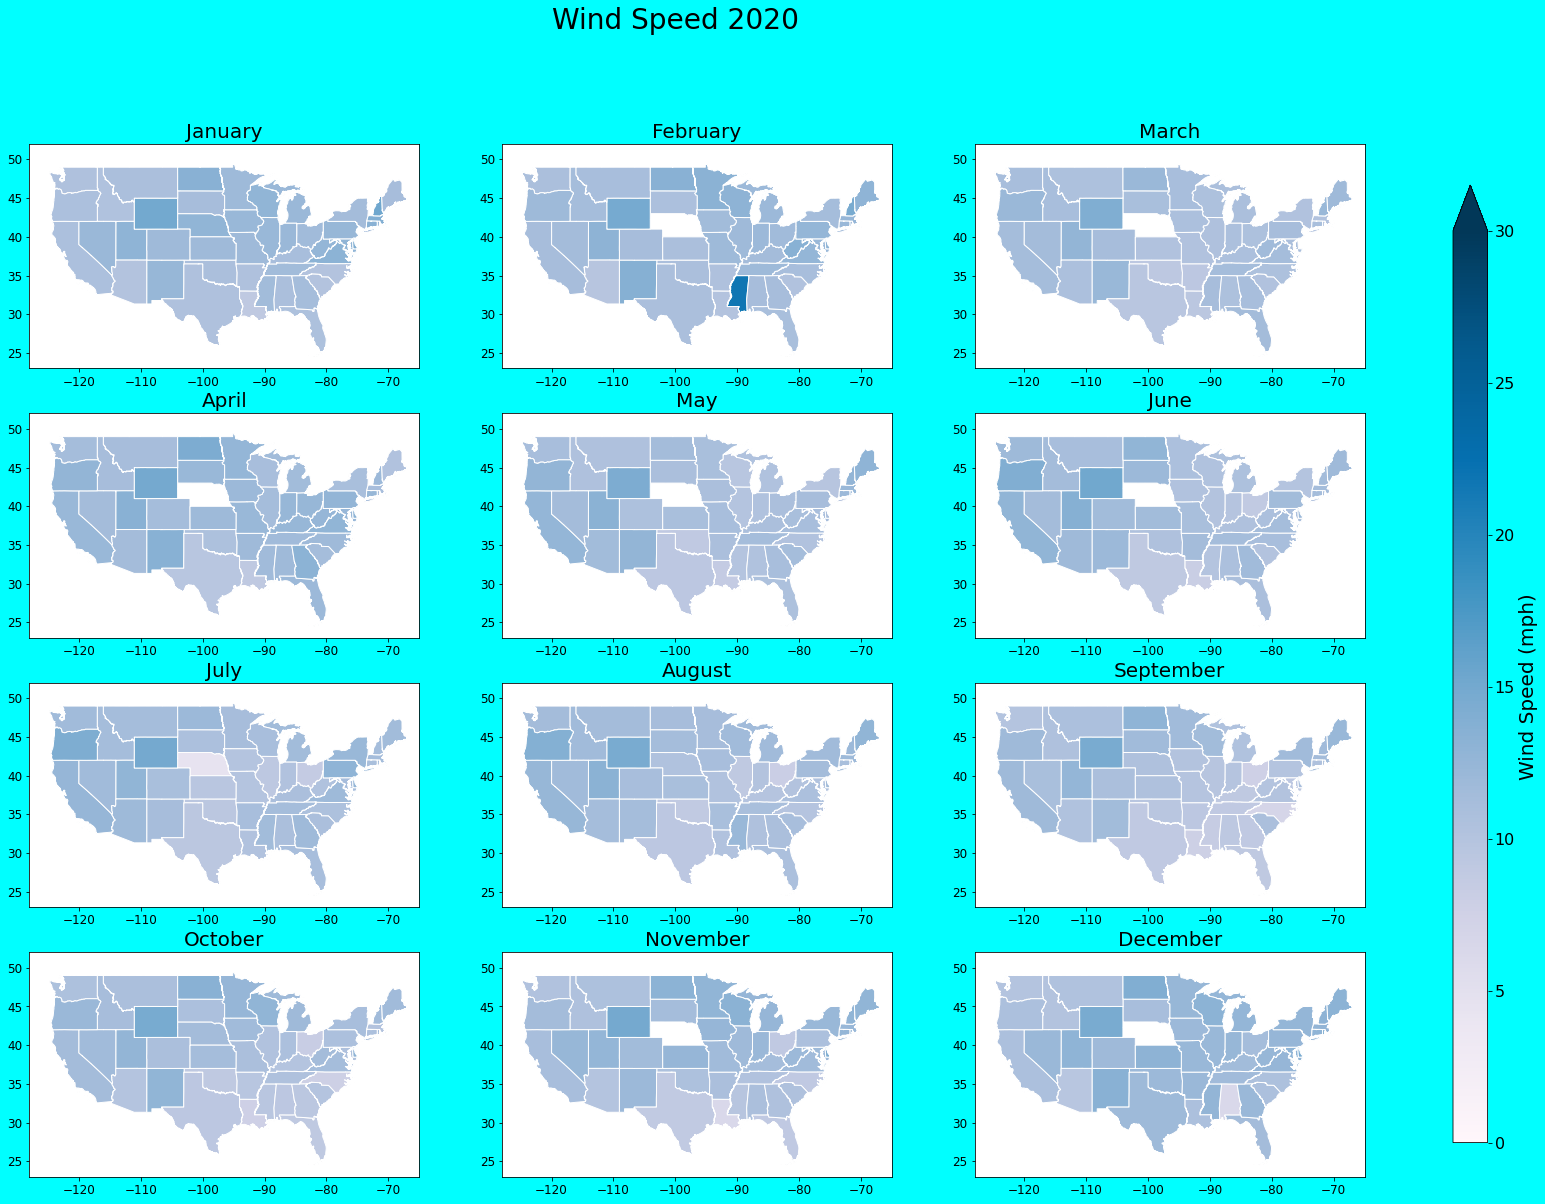

In [29]:
nrows,ncols=4,3
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9], [ax10, ax11, ax12]] = plt.subplots(nrows, 
                                                                                            ncols,
                                                                                            figsize = (24,19),
                                                                                            facecolor='cyan')
l1 = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]
fig.suptitle('Wind Speed 2020', fontsize=28)
norm = colors.Normalize(vmin=0, vmax=30)
for i in range (1,13):
    plt.subplot(nrows, ncols, i)
    data = df_month.precip[i-1, :, :].where(landmask)
    p = plt.pcolormesh(df_month.lon*0, df_month.lat*0, data, vmax = 30, cmap = 'PuBu')
    dd[i].plot(ax=l1[i-1], edgecolor='white', column='Wind Speed', legend=False, cmap='PuBu', norm=norm)
    plt.title(calendar.month_name[data.month.values], fontsize = 20)
    plt.xlim(-128,-65)
    plt.ylim(23,52)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)

cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = plt.colorbar(cax=cax, orientation='vertical', extend = 'max')
cb.ax.tick_params(labelsize=16)
cb.set_label(label='Wind Speed (mph)', size=20)

I thought it could be pertinent to plot the wind speed in order to study its relation to storm formation and eventually other parameters. However the wind speeds seem not to variate much during the year, and the dataset has some missing values. It appears that these wind speeds are not good indicators of storms, although it is a parameter used to define a storm (minimum wind speed required). This map is an average so it does not show maximum values. It would have been more interesting to look at maximum wind speed average per month (next plot).
Also, these wind speeds are measured at the ground level, which is not representative of the air movements happening in the upper atmosphere and that are responsible of storms.

In [30]:
df_w = pd.read_csv("daily_WIND_2020.csv")
df_w_2020 = df_w[['Latitude', 'Longitude', 'Date Local', '1st Max Value', 'State Name']]
df_w_2020 = df_w_2020.rename(columns={"Date Local": "Date", 
                                            "1st Max Value":"Wind Speed", 
                                            "State Name":"STATE"})
df_w_2020 = df_w_2020[df_w_2020['Longitude']>-130]
df_w_2020['Wind Speed']=df_w_2020['Wind Speed']*0.115078
df_w_2020['Date']=pd.to_datetime(df_w_2020["Date"]).dt.strftime('%m')
df_w_2020['Date'] = df_w_2020['Date'].astype(str).astype(int)
dfw = df_w_2020.groupby(["STATE", "Date"])["Wind Speed"].mean().to_frame().reset_index()
dfw['STATE']=dfw['STATE'].str.upper()
w = us.merge(dfw)

In [31]:
dd = {}
for i in range(1,13):
    dd[i] = w[w["Date"]==i]

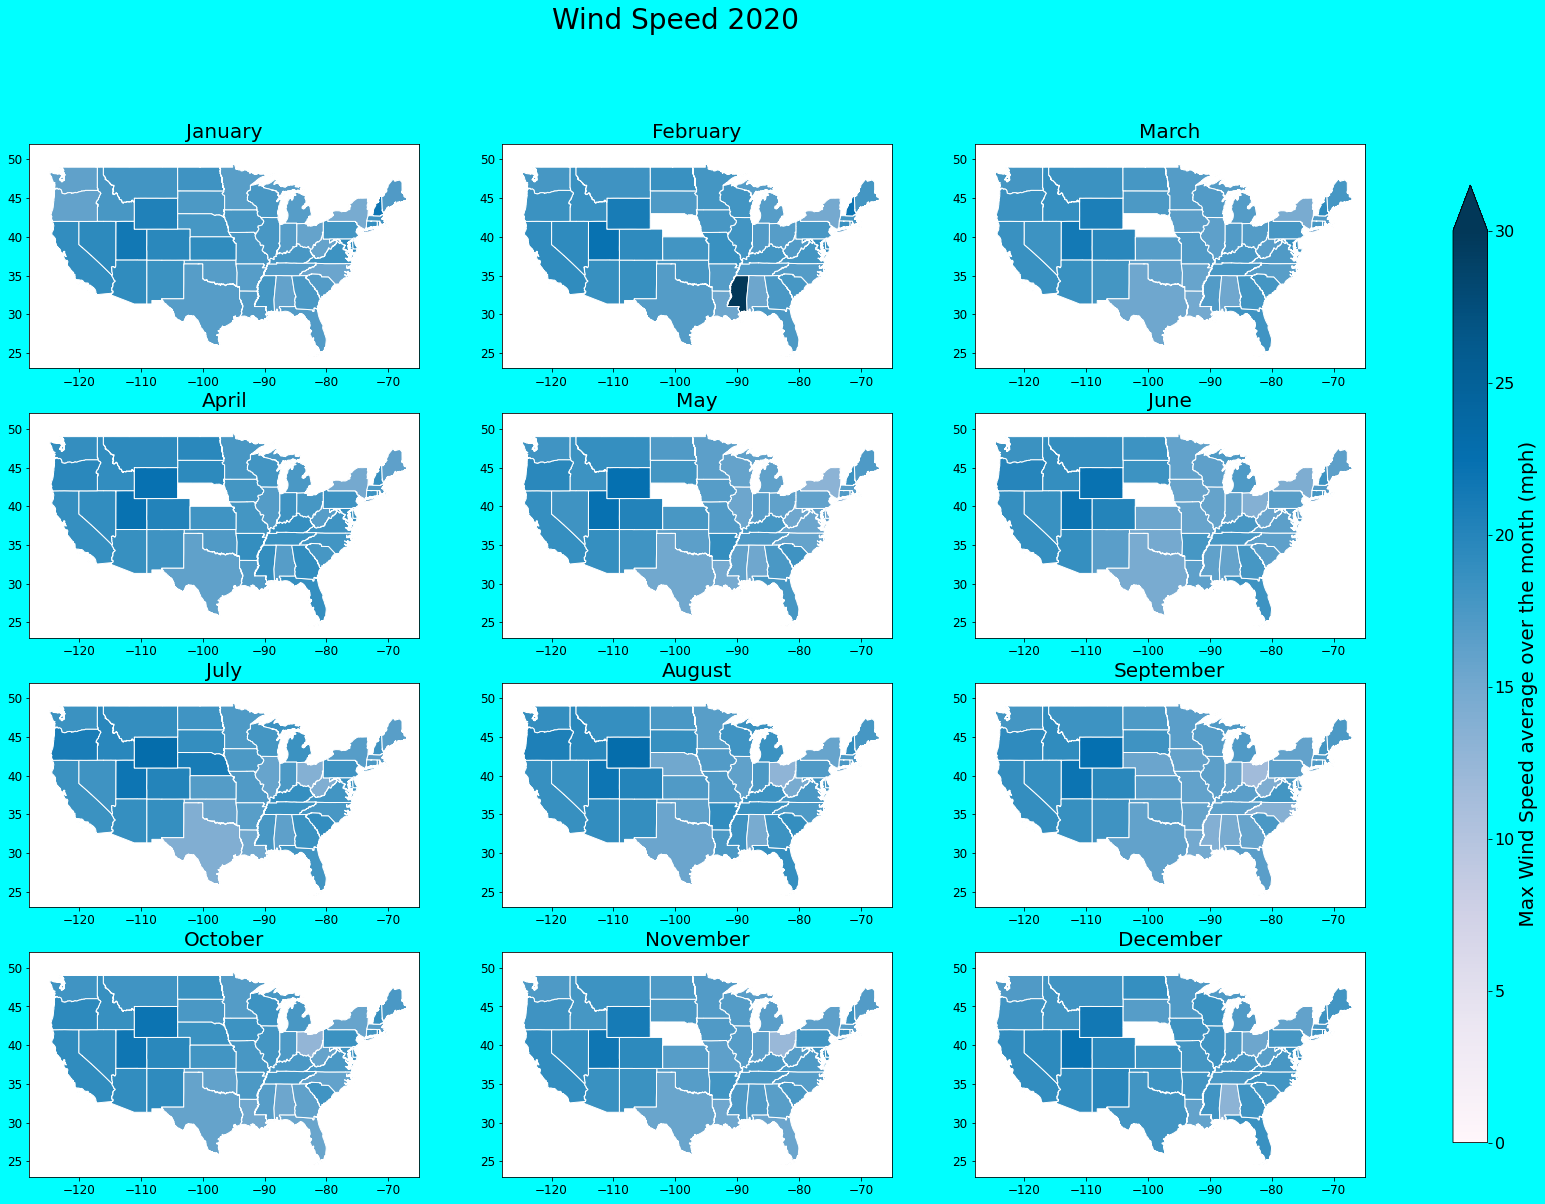

In [33]:
nrows,ncols=4,3
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9], [ax10, ax11, ax12]] = plt.subplots(nrows, 
                                                                                            ncols,
                                                                                            figsize = (24,19),
                                                                                            facecolor='cyan')
l1 = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]
fig.suptitle('Wind Speed 2020', fontsize=28)
norm = colors.Normalize(vmin=0, vmax=30)
for i in range (1,13):
    plt.subplot(nrows, ncols, i)
    data = df_month.precip[i-1, :, :].where(landmask)
    p = plt.pcolormesh(df_month.lon*0, df_month.lat*0, data, vmax = 30, cmap = 'PuBu')
    dd[i].plot(ax=l1[i-1], edgecolor='white', column='Wind Speed', legend=False, cmap='PuBu', norm=norm)
    plt.title(calendar.month_name[data.month.values], fontsize = 20)
    plt.xlim(-128,-65)
    plt.ylim(23,52)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)

cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = plt.colorbar(cax=cax, orientation='vertical', extend = 'max')
cb.ax.tick_params(labelsize=16)
cb.set_label(label=' Max Wind Speed average over the month (mph)', size=20)

This plot is not far batter than the previous one. The only noticeable thing is the anomaly in the wind speed average in Mississippi in February 2020, which is confirmed by the news and events at that period (tornadoes).

## Conclusion

Knowing the level of precipitation and temperature are very good indicators of the formation of a storm. A next interesting step to this project could be to retrieve data from 1950 to 2020 to compare the evolution of all these parameters. It could also be intersting to create a little algorithm that predicts the probability of having a storm formed based on the level of precipitation and temperature.